For the [Accountability hack](https://accountabilityhack.nl/) I am cleaning up data regarding tenders in the Netherlands. These are published on https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen, and this data is in some rough shape. This is a notebook that cleans it up. I will also include a script that does it.   

First, I extract the relevant links to datasets from the page. 

In [128]:
from bs4 import BeautifulSoup
import requests

url = "https://www.tenderned.nl/over-tenderned/datasets-aanbestedingen"

soup  = BeautifulSoup(requests.get(url).content, "html.parser")

links = [link for link in [a.attrs["href"] for a in soup.find_all("a")] if "Dataset" in link]
links

['https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q1_Q2.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2016_Q3_Q4_0.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2015.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2014.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2013.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2012.xlsx',
 'https://www.tenderned.nl/sites/default/files//Dataset_TenderNed_2010_2011.xlsx']

It's useful to have a list of shorter names as well. I use pandas to read all the excel files as `pd.DataFrame`. 

In [129]:
import re
import pandas as pd

# i'll need this later
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

names = [re.match(r'.*TenderNed_(.*)\.xlsx', link).groups()[0] for link in links]
frames = [pd.read_excel(link) for link in links]

names

['2016_Q1_Q2', '2016_Q3_Q4_0', '2015', '2014', '2013', '2012', '2010_2011']

The colums are not the same among all of the frames, so let's create a heatmap to see what's missing where. 

In [130]:
import seaborn.apionly as sns
from functools import reduce

%pylab inline

Populating the interactive namespace from numpy and matplotlib


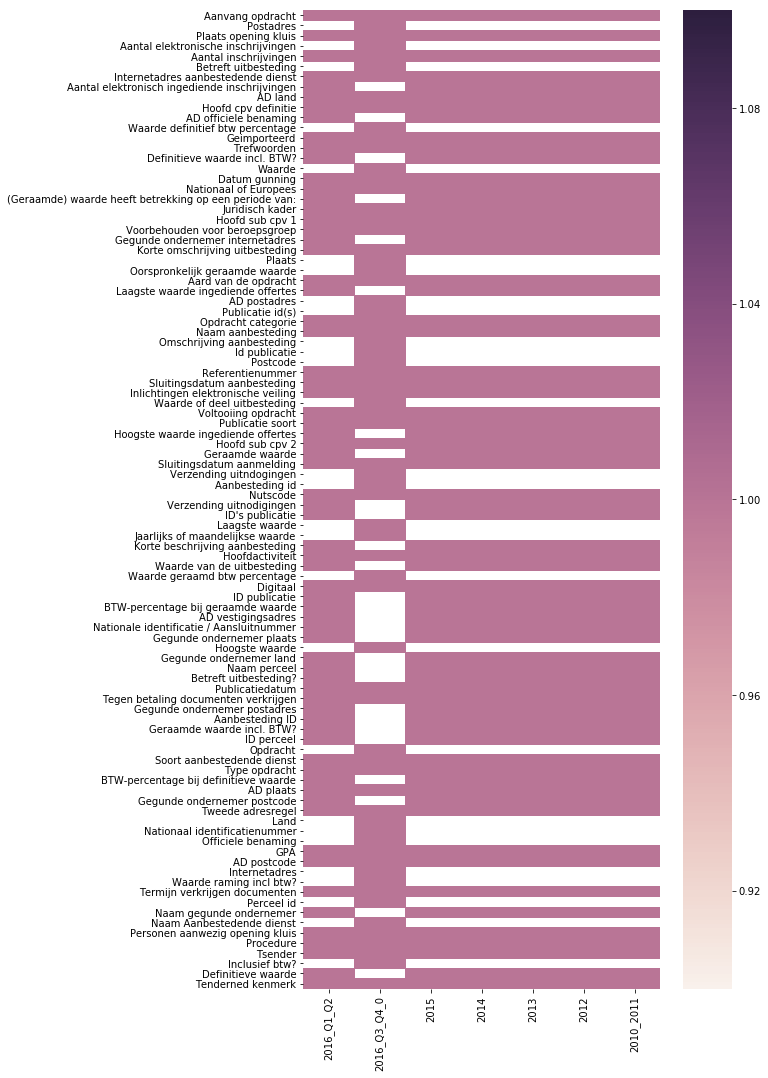

In [131]:
all_columns = set(reduce(lambda x, y: x + y, [list(df.columns) for df in frames]))

missing = pd.DataFrame(index=all_columns)

for name, frame in zip(names, frames):
    
    missing.loc[frame.columns, name] = 1 

plt.figure(figsize = (8, 18))
sns.heatmap(missing)

Allright. I don't like the ugly column names, with spaces, and some even have a question mark at the end. WTF? Unfortunately, there is no functionality like `janitor::clean_names` in `R` available in python (anyone?), so I'll hack my own for now. 

In [132]:
import string

def sanitize(name):
    
    t = "".join([c if c in string.ascii_lowercase + string.digits else "_" for c in name.lower()])
    return re.sub(r"_+", "_", t).lstrip("_").rstrip("_")
     
sanitize(df.columns[-3])

'betreft_uitbesteding'

Now I'll merge the frames, except the one with the different column names, into one, while also sanitizing each frame and adding a reference to the source. 

In [133]:
def transform(df, name, link):

    return df.rename(columns=sanitize).assign(
        name = name,
        link = link
    )

clean_frames = [transform(df, name, link) for df, name, link in zip(frames, names, links) if not "2016_Q3" in name]

tenders = pd.concat(clean_frames)
tenders.head()

In [134]:
tenders.shape

(58289, 70)

The first thing I always do in a dataset is checking the id's, and if they're actually unique. Terrible datasets have duplicated id's, many of them, and have all kinds of redundant data. This one, as mentioned earlier, is terrible. Let's count the duplicates and null values in each column to see if we can make something of that. 

In [127]:
def count_dupes(col):
    return pd.Series({
        "duplications": col.duplicated().sum(), 
        "unique_values": len(col.unique()),
        "na": col.isnull().sum(), 
        "na + duplications": (col.duplicated() | col.isnull()).sum()
    })

tenders.apply(count_dupes, axis = 0).T.sort_values("duplications")

,duplications,na,na + duplications,unique_values
id_publicatie,14994,0,14994,43295
tenderned_kenmerk,33137,0,33137,25152
aanbesteding_id,33137,0,33137,25152
korte_beschrijving_aanbesteding,35803,51,35804,22486
naam_aanbesteding,36222,0,36222,22067
referentienummer,41271,13614,41272,17018
trefwoorden,48636,10465,48637,9653
naam_gegunde_ondernemer,50474,29203,50475,7815
id_s_publicatie,50999,29203,51000,7290
gegunde_ondernemer_postcode,51968,29432,51969,6321
